1. 准备数据集

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 数据变换，将单通道灰度图转换为3通道并调整大小
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # 转换为3通道
    transforms.Resize((32, 32)),  # 调整到32x32
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST归一化参数
])

# 加载MNIST数据集
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

Using device: cuda


100%|██████████| 9.91M/9.91M [00:04<00:00, 2.01MB/s]

100%|██████████| 28.9k/28.9k [00:00<00:00, 94.5kB/s]

100%|██████████| 1.65M/1.65M [00:01<00:00, 900kB/s] 

100%|██████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]

训练集大小: 60000
测试集大小: 10000


2. 构建模型

In [2]:
from torchvision.models import mobilenet_v2

class MobileNetV2Classifier(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(MobileNetV2Classifier, self).__init__()
        
        # 加载预训练的MobileNetV2模型
        self.backbone = mobilenet_v2(pretrained=pretrained)
        
        # 冻结预训练层
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # 替换分类器
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.backbone.last_channel, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)

# 创建模型实例
model = MobileNetV2Classifier(num_classes=10, pretrained=True)
model = model.to(device)

# 打印模型信息
print("模型结构:")
print(model)
print(f"\n总参数数量: {sum(p.numel() for p in model.parameters())}")
print(f"可训练参数数量: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

c:\Users\2022\anaconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\2022\anaconda3\envs\py39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\2022/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:01<00:00, 7.36MB/s]



模型结构:
MobileNetV2Classifier(
  (backbone): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 9

3. 编译和训练模型

In [3]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练函数
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, '
                      f'Loss: {loss.item():.4f}, '
                      f'Accuracy: {100.*correct/total:.2f}%')
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

# 开始训练
print("开始初始训练...")
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

开始初始训练...
Epoch 1/10, Batch 0, Loss: 2.4762, Accuracy: 6.25%
Epoch 1/10, Batch 0, Loss: 2.4762, Accuracy: 6.25%
Epoch 1/10, Batch 100, Loss: 1.5794, Accuracy: 46.16%
Epoch 1/10, Batch 100, Loss: 1.5794, Accuracy: 46.16%
Epoch 1/10, Batch 200, Loss: 1.3180, Accuracy: 53.81%
Epoch 1/10, Batch 200, Loss: 1.3180, Accuracy: 53.81%
Epoch 1/10, Batch 300, Loss: 1.1921, Accuracy: 56.60%
Epoch 1/10, Batch 300, Loss: 1.1921, Accuracy: 56.60%
Epoch 1/10, Batch 400, Loss: 0.8807, Accuracy: 59.15%
Epoch 1/10, Batch 400, Loss: 0.8807, Accuracy: 59.15%
Epoch 1/10, Batch 500, Loss: 0.8947, Accuracy: 60.24%
Epoch 1/10, Batch 500, Loss: 0.8947, Accuracy: 60.24%
Epoch 1/10, Batch 600, Loss: 0.6066, Accuracy: 61.00%
Epoch 1/10, Batch 600, Loss: 0.6066, Accuracy: 61.00%
Epoch 1/10, Batch 700, Loss: 1.5210, Accuracy: 61.48%
Epoch 1/10, Batch 700, Loss: 1.5210, Accuracy: 61.48%
Epoch 1/10, Batch 800, Loss: 1.3377, Accuracy: 62.14%
Epoch 1/10, Batch 800, Loss: 1.3377, Accuracy: 62.14%
Epoch 1/10, Batch 900, L

4. 微调模型

In [4]:
# 微调：解冻部分层进行训练
print("开始微调...")

# 解冻backbone的后几层
for param in model.backbone.features[-4:].parameters():
    param.requires_grad = True

# 使用更小的学习率进行微调
optimizer_finetune = optim.Adam([
    {'params': model.backbone.classifier.parameters(), 'lr': 0.001},
    {'params': model.backbone.features[-4:].parameters(), 'lr': 0.0001}
])

print(f"微调阶段可训练参数数量: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# 微调训练
finetune_losses, finetune_accuracies = train_model(
    model, train_loader, criterion, optimizer_finetune, num_epochs=5
)

开始微调...
微调阶段可训练参数数量: 1538890
Epoch 1/5, Batch 0, Loss: 1.2523, Accuracy: 56.25%
Epoch 1/5, Batch 100, Loss: 1.1019, Accuracy: 68.19%
Epoch 1/5, Batch 100, Loss: 1.1019, Accuracy: 68.19%
Epoch 1/5, Batch 200, Loss: 1.0645, Accuracy: 70.26%
Epoch 1/5, Batch 200, Loss: 1.0645, Accuracy: 70.26%
Epoch 1/5, Batch 300, Loss: 0.6667, Accuracy: 71.46%
Epoch 1/5, Batch 300, Loss: 0.6667, Accuracy: 71.46%
Epoch 1/5, Batch 400, Loss: 0.7234, Accuracy: 72.54%
Epoch 1/5, Batch 400, Loss: 0.7234, Accuracy: 72.54%
Epoch 1/5, Batch 500, Loss: 0.5615, Accuracy: 73.76%
Epoch 1/5, Batch 500, Loss: 0.5615, Accuracy: 73.76%
Epoch 1/5, Batch 600, Loss: 0.6419, Accuracy: 74.49%
Epoch 1/5, Batch 600, Loss: 0.6419, Accuracy: 74.49%
Epoch 1/5, Batch 700, Loss: 1.0803, Accuracy: 75.23%
Epoch 1/5, Batch 700, Loss: 1.0803, Accuracy: 75.23%
Epoch 1/5, Batch 800, Loss: 0.8741, Accuracy: 76.01%
Epoch 1/5, Batch 800, Loss: 0.8741, Accuracy: 76.01%
Epoch 1/5, Batch 900, Loss: 0.6367, Accuracy: 76.45%
Epoch 1/5, Batch 90

5. 模型评估

In [5]:
# 模型评估
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    
    return test_loss, accuracy, np.array(all_predictions), np.array(all_targets)

# 评估模型
test_loss, test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)

print(f"测试损失: {test_loss:.4f}")
print(f"测试准确率: {test_accuracy:.2f}%")

测试损失: 0.2787
测试准确率: 91.95%


6. 可视化模型性能

c:\Users\2022\anaconda3\envs\py39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\2022\anaconda3\envs\py39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\2022\anaconda3\envs\py39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\2022\anaconda3\envs\py39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\2022\anaconda3\envs\py39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDE

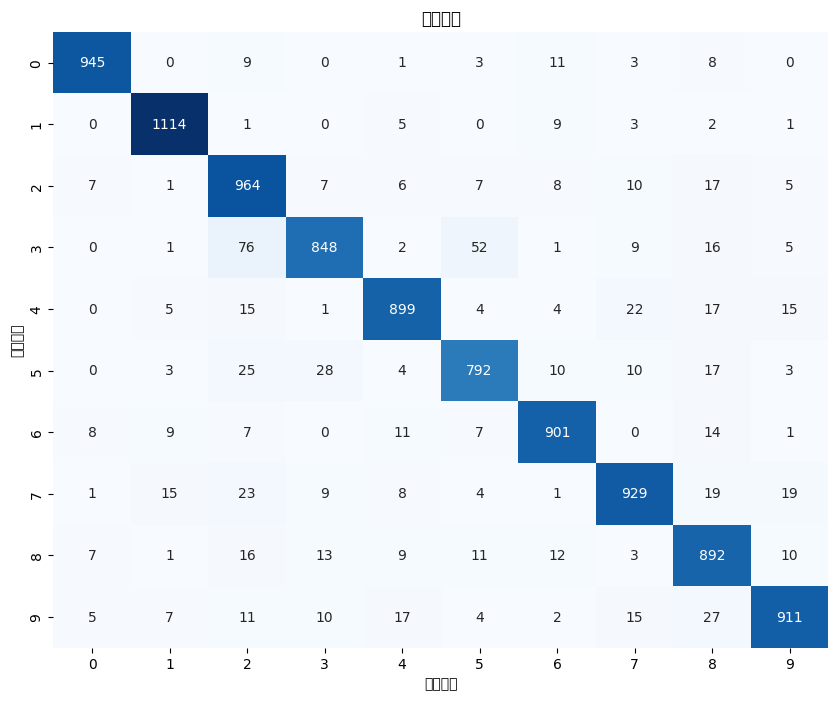

分类报告:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.84      0.93      0.88      1032
           3       0.93      0.84      0.88      1010
           4       0.93      0.92      0.92       982
           5       0.90      0.89      0.89       892
           6       0.94      0.94      0.94       958
           7       0.93      0.90      0.91      1028
           8       0.87      0.92      0.89       974
           9       0.94      0.90      0.92      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 生成混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title('混淆矩阵')
plt.show()

# 打印分类报告
print("分类报告:")
print(classification_report(true_labels, predictions, target_names=[str(i) for i in range(10)]))

7. 示例图像可视化

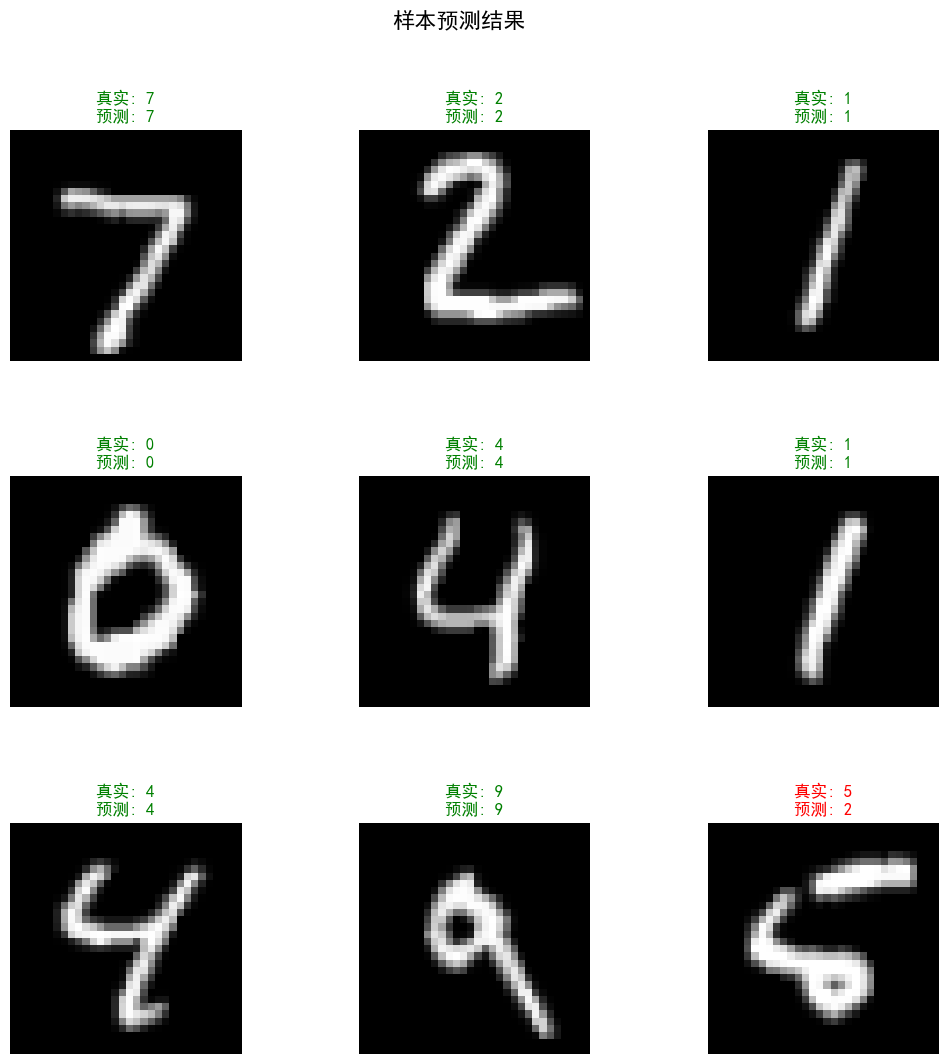

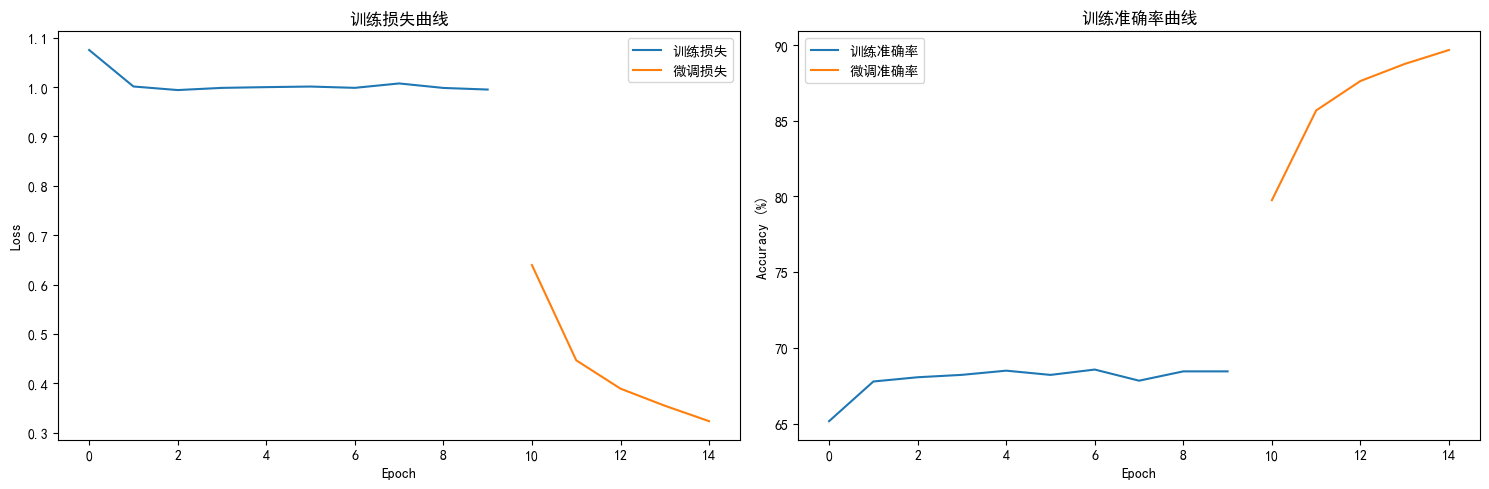

In [8]:
# plt中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# 示例图像可视化
def display_sample_predictions(model, test_loader, num_samples=9):
    model.eval()
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    # 获取一批测试数据
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # 显示前9张图像
    for i in range(min(num_samples, len(images))):
        ax = axes[i // 3, i % 3]
        
        # 将图像转换回灰度显示（取第一个通道）
        img = images[i].cpu().numpy()[0]  # 取第一个通道
        ax.imshow(img, cmap='gray')
        
        true_label = labels[i].item()
        pred_label = predicted[i].cpu().item()
        
        # 设置标题，如果预测正确用绿色，错误用红色
        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f'真实: {true_label}\n预测: {pred_label}', color=color)
        ax.axis('off')
    
    plt.suptitle('样本预测结果', fontsize=16)
    plt.show()

# 显示样本预测结果
display_sample_predictions(model, test_loader)

# 绘制训练曲线
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='训练损失')
if 'finetune_losses' in locals():
    plt.plot(range(len(train_losses), len(train_losses) + len(finetune_losses)), 
             finetune_losses, label='微调损失')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('训练损失曲线')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='训练准确率')
if 'finetune_accuracies' in locals():
    plt.plot(range(len(train_accuracies), len(train_accuracies) + len(finetune_accuracies)), 
             finetune_accuracies, label='微调准确率')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('训练准确率曲线')
plt.legend()

plt.tight_layout()
plt.show()